# Calculate 2D PMFs from joint probability distributions
We use **lipyphilic** to plot a two-dimensional potential of mean force (PMF) of cholesterol height and orientation in a planar bilayer. We will use the equimolar ternary mixture of DPPC, DOPC, and cholesterol studied by [Smith et al.](https://www.biorxiv.org/content/10.1101/2021.05.24.445501v3)

First we will determine the height and orientation using `lipyphilic.lib.z_positions.ZPositions` and `lipyphilic.lib.z_angles.ZAngles`, respectively.

Then we will use `lipyphilic.lib.plotting.JointDensity` to plot the two-dimensional PMF of height and orientation.

Note
----
Using `lipyphilic.lib.plotting.JointDensity` to calculate the PMF of orientation and height is arbitrary - `JointDensity` can be used to plot the 2D PMF of any two observables.


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import MDAnalysis as mda

from lipyphilic.lib.z_positions import ZPositions
from lipyphilic.lib.z_angles import ZAngles
from lipyphilic.lib.plotting import JointDensity


## Load the topology and trajectory using MDAnalysis

In [3]:
u = mda.Universe("../datafiles/dppc-dopc-chol.tpr", "../datafiles/dppc-dopc-chol.xtc")

## Cholesterol height in the membrane

We will first use `ZPositions` to calculate the height of each cholesterol molecule within the bilayer.

We need to pass our universe, along with the following parameters:

- `lipid_sel`: atom selection covering **all** lipids in the bilayer
- `height_sel` : atom selection for the molecules for which the $z$ position will be calculated 

The midpoint of the bilayer will be calculated using the atoms selected by `lipid_sel`. Then, the signed distance in $z$ from the midpoint will be calculated for each molecule using the atoms selected bt `height_sel`.

By default, a single membrane midpoint is used in the calculation. However, we will also use the optional `n_bins` keyword to split the membrane  $n_{\rm bins} * n_{\rm bins}$ patches. A local membrane midpoint is calculated for each bilayer patch, and heights calculated based on signed distances to the relevant local membrane midpoint.


In [6]:
height = ZPositions(
    universe=u,
    lipid_sel="name GL1 GL2 ROH",  # selects the glycerol backbone of phospholipids and hydroxyl group of cholesterol
    height_sel="name ROH",  # consider only cholesterol, ignore the phospholipids
    n_bins=10  # split the membrane into a 10 by 10 grid and cal
)


We then select which frames of the trajectory to analyse (`None` will use every frame) and choose to display a progress bar (`verbose=True`)::

In [7]:
height.run(
    start=None,
    stop=None,
    step=None,
    verbose=True
)


  0%|          | 0/51 [00:00<?, ?it/s]

## Cholesterol orientation in the membrane

We will use `ZAngles` to calculate the orientation with respect to the positive $z$ axis of each cholesterol molecule in the bilayer.

Two atoms must be selected per lipid, and the angle between the $z$ axis and the vector joining the two atoms will be calculated for each lipid. The
vector will always point from atom B to atom A, even for lipids in the lower leaflet. This means the angle $\theta_{ABz}$ will be in the range
$-180° < \theta < 180°$.

We need to pass our universe, along with the following parameters:

- `atom_A_sel` : atom selection for atom A in each lipid
- `atom_B_sel` : atom selection for atom B in each lipid


In [9]:
angles = ZAngles(
    universe=u,
    atom_A_sel="name R5",  # cyclic ring nearest the aliphatic tail of cholesterol
    atom_B_sel="name ROH"  # hydroxyl headgroup of cholesterol
)


We then select which frames of the trajectory to analyse (`None` will use every frame) and choose to display a progress bar (`verbose=True`)::

In [10]:
angles.run(start=-500, stop=None, step=None, verbose=True)

  0%|          | 0/51 [00:00<?, ?it/s]

# Plot the height-orientation PMF

We are now ready to plot the two-dimensional PMF of cholesterol orientation and height using `JointDensity`.

We first need to **initialise our plotting object** by passing the results from `ZAngles` and `ZPositions` to the `ob1` and `ob2` keywords of `JointDensity`.

Note, `ob1` and `ob2` can be any two observables,  but they must have the same number of data points.


In [11]:
pmf = JointDensity(
    ob1=angles.z_angles,
    ob2=height.z_positions
)


To calculate the PMF, we must specifiy the temperature (in K) at which the simulation was performed. We pass this to the `calc_density_2D` function of `JointDensity`, which will create a two-dimensional histogram of the heights and orientations.

We will also the number of bins to use in constructing the hisogram.


In [12]:
temperature = 300
angle_bins = np.linspace(0, 180, 181)
height_bins = np.linspace(-30, 30, 61)


In [14]:
pmf.calc_density_2D(
    bins=(angle_bins, height_bins),
    temperature=temperature
)


Now we will remove any NaN values from our histogram through a linear interpolation:


In [15]:
pmf.interpolate()

And finally, we will **plot the results**

We specify the maximum allowed value of the PMF with `vmax`. All values above this cutoff will be coloured the same.


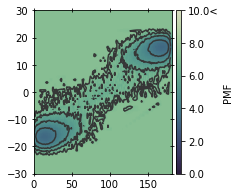

In [16]:
vmax = 10

pmf.plot_density(
    vmax=vmax
)


# Control aesthetics

There are many options that we can use to control the aesthetics of out plot. Below we will look at some of these options.

**We can change the aesthetics of our plot without creating a new object - we simply need to call `plot_density` again**


In [19]:
title = "PMF at 300 K"
xlabel = r"$\theta_Z\ \rm (\degree)$"
ylabel= r"$z\ \rm (\AA)$"

# minimum and maximum values of the colourbar
vmin = 0
vmax = 10

# label the first 2 contours with their values
# This makes it easy to know the gradient across each contour
contour_labels = [1, 2]  # which contours to label
clabel_kws = {
    "fontsize": 12,  # font size of contour label
    "inline": True,  # break the contour to write the label
    "fmt": "%.1f"    # precision of contour value
}


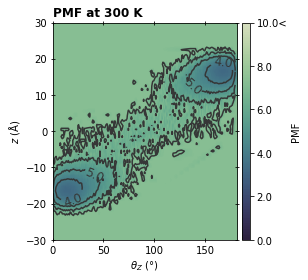

In [20]:
fig, ax = plt.subplots(1, figsize=(4, 4), sharey=True, sharex=True)

pmf.plot_density(
    ax=ax,
    title=title,
    ylabel=ylabel,
    xlabel=xlabel,
    vmin=vmin, vmax=vmax,
    contour_labels=contour_labels,
    clabel_kws=clabel_kws
)
